<a href="https://colab.research.google.com/github/hasan-nn/BirdCliff22_solution/blob/main/July2023/WaterDetect_July2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%pip install sentinelhub==3.8.0
%pip install sentinelhub
%pip install earthpy
%pip install geopandas
%pip install eo-learn
#%pip install "eo-learn.core==0.10.1" "eo-learn.coregistration==0.10.1" "eo-learn.features==0.10.1" "eo-learn.geometry==0.10.1" "eo-learn.io==0.10.1" "eo-learn.mask==0.10.1" "eo-learn.ml_tools==0.10.1" "eo-learn.visualization==0.10.1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.4/244.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 52.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 5.4 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6085 sha256=799637f2a3d6dac817b5a71a499c43306dfcac6e8e7eb7db33c76bb62a535d36
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.3 MB/s eta 0:00:00


In [3]:
!pip show sentinelhub
%pip show eo-learn.core

Name: sentinelhub
Version: 3.9.1
Summary: Python API for Sentinel Hub
Home-page: 
Author: 
Author-email: Sinergise EO research team <eoresearch@sinergise.com>
License: MIT License
        
        Copyright (c) 2018 Sinergise Ltd.
        
        Permission is hereby granted, free of charge, to any person obtaining a copy
        of this software and associated documentation files (the "Software"), to deal
        in the Software without restriction, including without limitation the rights
        to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
        copies of the Software, and to permit persons to whom the Software is
        furnished to do so, subject to the following conditions:
        
        The above copyright notice and this permission notice shall be included in all
        copies or substantial portions of the Software.
        
        THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
        IMPLIED, INCLUDING BUT NOT 

In [ ]:
#need to restart run time after installing shapely
import os
os.kill(os.getpid(), 9)

In [1]:
#example followed:
#https://eo-learn.readthedocs.io/en/latest/examples/water-monitor/WaterMonitorWorkflow.html

#Imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# data manipulation
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# image manipulations
from skimage.filters import threshold_otsu, sobel
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, disk

# GIS related
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import shape, MultiPolygon, Polygon

# eo-learn related
from eolearn.core import EOTask, EOWorkflow, EOPatch, linearly_connect_tasks, FeatureType, OutputTask

# filtering of scenes
from eolearn.features import SimpleFilterTask, NormalizedDifferenceIndexTask

# burning the vectorised polygon to raster
from eolearn.geometry import VectorToRasterTask

# Sentinel Hub
from sentinelhub import BBox, CRS
# from sentinelhub.data_request import WmsRequest, WcsRequest
from sentinelhub.constants import MimeType

In [2]:
import urllib.request as request
import json
import shapely.wkt
from datetime import datetime
from shapely.wkt import loads
from shapely.geometry import Polygon

# sentinelhub-py package
from sentinelhub import BBox, CRS,DataCollection

In [3]:
%matplotlib inline
import datetime as dt

In [4]:
from skimage.filters import sobel
from skimage.morphology import disk
from skimage.morphology import erosion, dilation, opening, closing, white_tophat

In [5]:
from eolearn.io import SentinelHubDemTask, SentinelHubEvalscriptTask, SentinelHubInputTask

In [6]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from sentinelhub import SHConfig

# Your client credentials
client_id = 'sh-76406cb6-3b67-46bf-b39a-260b1e7b7413'
client_secret = 'GJ8JAOM7VNnKfMKDSJRlP0WbrQm8A0bZ'

config = SHConfig()

config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_client_id = client_id
config.sh_client_secret = client_secret
config.sh_client_id = client_id
config.sh_client_secret = client_secret
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save()

!sentinelhub.config --show

{
  "instance_id": "",
  "sh_client_id": "sh-76406cb6-3b67-46bf-b39a-260b1e7b7413",
  "sh_client_secret": "GJ8JAOM7VNnKfMKDSJRlP0WbrQm8A0bZ",
  "sh_base_url": "https://sh.dataspace.copernicus.eu",
  "sh_auth_base_url": null,
  "sh_token_url": "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
  "geopedia_wms_url": "https://service.geopedia.world",
  "geopedia_rest_url": "https://www.geopedia.world/rest",
  "aws_access_key_id": "",
  "aws_secret_access_key": "",
  "aws_session_token": "",
  "aws_metadata_url": "https://roda.sentinel-hub.com",
  "aws_s3_l1c_bucket": "sentinel-s2-l1c",
  "aws_s3_l2a_bucket": "sentinel-s2-l2a",
  "opensearch_url": "http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2",
  "max_wfs_records_per_query": 100,
  "max_opensearch_records_per_query": 500,
  "max_download_attempts": 4,
  "download_sleep_time": 5.0,
  "download_timeout_seconds": 120.0,
  "number_of_download_processes": 1
}
Configuration file locat

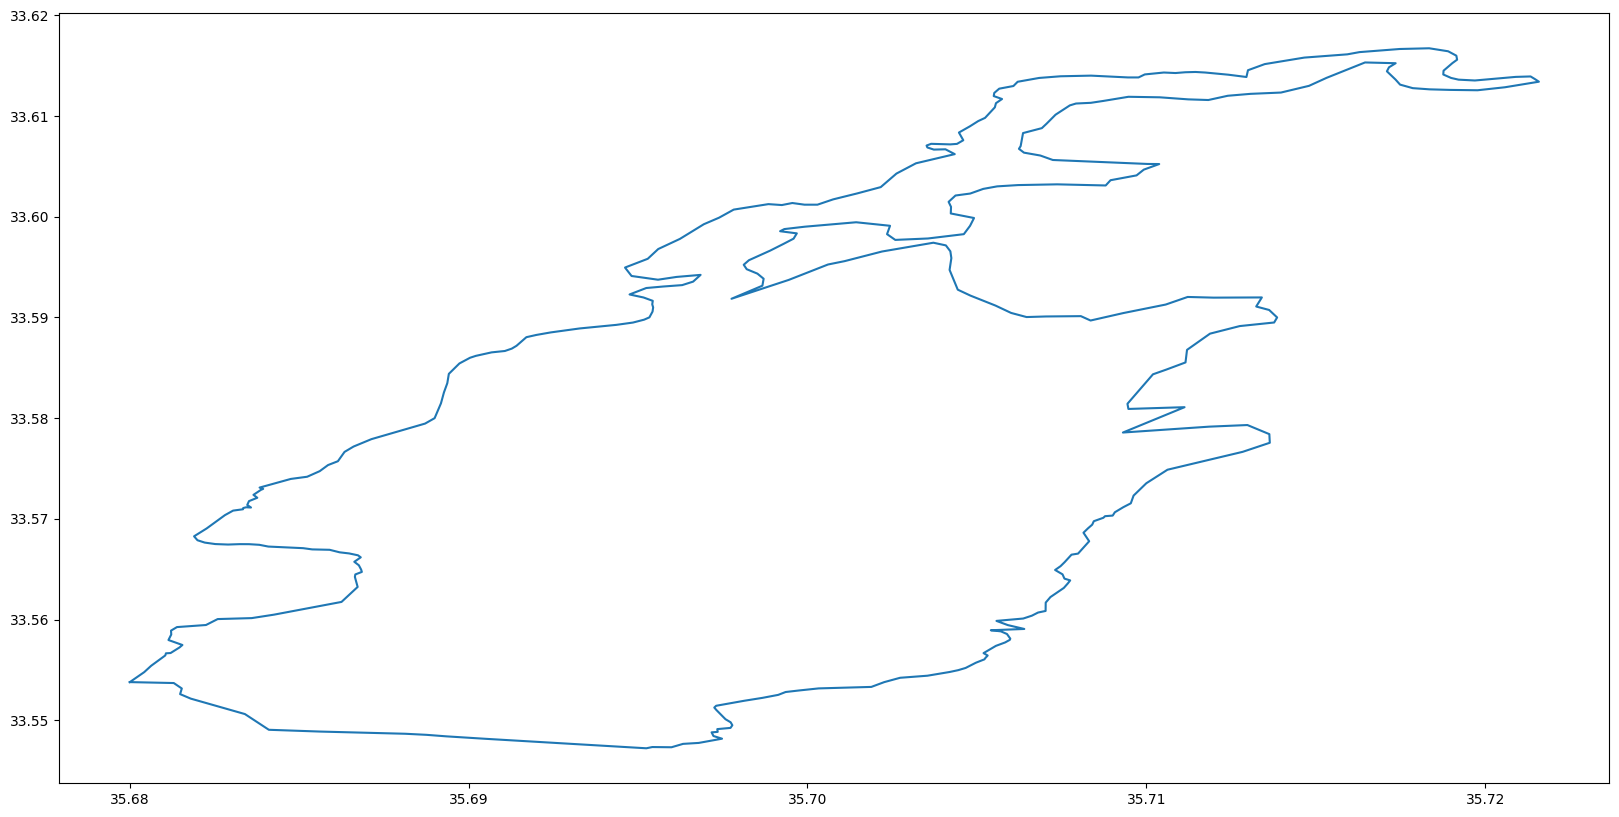

In [7]:
# function for obtaining the nominal water geometry from the water observatory API
def get_nominal_geometry():
    wb_url = f'https://water.blue-dot-observatory.com/api/waterbodies/38784/index.html'
    with request.urlopen(wb_url) as url:
        wb_data = json.loads(url.read().decode())
        nominal_outline = shape(wb_data['nominal_outline']['geometry'])
    return nominal_outline

def plot_geometry(geom, ax = None, **kwargs):

    if geom is None:
        return
    if geom.exterior is None:
        return

    x,y = geom.exterior.xy

    if ax is None:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(111)


    ax.plot(x, y, **kwargs)

# get the nominal geometry
geom = get_nominal_geometry()

# and plot it
plot_geometry(geom)

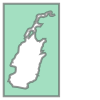

In [8]:
inflate_bbox = 0.1
minx, miny, maxx, maxy = geom.bounds
delx = maxx - minx
dely = maxy - miny
minx = minx - delx * inflate_bbox
maxx = maxx + delx * inflate_bbox
miny = miny - dely * inflate_bbox
maxy = maxy + dely * inflate_bbox
dam_bbox = BBox([minx, miny, maxx, maxy], crs=CRS.WGS84)

dam_bbox.geometry - geom

In [9]:
dam_gdf = gpd.GeoDataFrame(crs=CRS.WGS84.pyproj_crs(), geometry=[geom])

<Figure size 2000x1000 with 0 Axes>

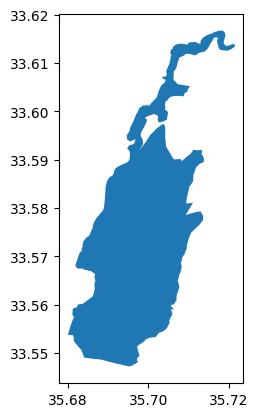

In [10]:
fig = plt.figure(figsize=(20,10))
dam_gdf.plot();

Create an EOPatch and add all EO features

In [11]:
download_task = SentinelHubInputTask(data_collection=DataCollection.SENTINEL2_L1C.define_from("cdse_sentinel2_l1c", service_url="https://sh.dataspace.copernicus.eu"),
                                     bands_feature=(FeatureType.DATA, 'BANDS'),
                                     resolution=20,
                                     maxcc=0.1,
                                     bands=['B02', 'B03', 'B04', 'B08', 'B11', 'B12'],
                                     time_difference=dt.timedelta(hours=2),
                                     #additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'), (FeatureType.MASK, 'CLM')],
                                     additional_data=(FeatureType.MASK, 'dataMask', 'IS_DATA'),
                                    )

to use different indices replace MNDWI in cell 25 and 29 by SWI ,AWEL ...

In [12]:
band_names = ['B05', 'B03', 'B04', 'B08', 'B11', 'B12']

#For use NDWI
#our_index= NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDWI'), (1, 3))

# # For use SWI
# indice=NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'SWI'),
#                                      [band_names.index('B05'), band_names.index('B08')])

# For use MNDWI
our_index=calculate_mndwi=NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'MNDWI'),
                                     [band_names.index('B03'), band_names.index('B11')])

# # For use AWEI
# indice= NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'AWEI'), (1, 3))


In [13]:
add_nominal_water = VectorToRasterTask(dam_gdf, (FeatureType.MASK_TIMELESS, 'NOMINAL_WATER'), values=1,
                                   raster_shape=(FeatureType.MASK, 'IS_DATA'), raster_dtype=np.uint8)

Calculate fraction of valid pixels per frame

In [ ]:
# def calculate_valid_data_mask(eopatch):
#     is_data_mask = eopatch.mask['IS_DATA'].astype(np.bool)
#     cloud_mask = ~eopatch.mask['CLM'].astype(np.bool)
#     return np.logical_and(is_data_mask, cloud_mask)

# add_valid_mask = AddValidDataMaskTask(predicate=calculate_valid_data_mask)

In [14]:
class AddValidDataMaskTask(EOTask):
    def execute(self, eopatch):
        is_data_mask = eopatch[FeatureType.MASK, "IS_DATA"].astype(bool)
        #cloud_mask = ~eopatch[FeatureType.MASK, "CLM"].astype(bool)
        eopatch[FeatureType.MASK, "VALID_DATA"] = np.logical_and(is_data_mask, is_data_mask)
        return eopatch


add_valid_mask = AddValidDataMaskTask()

In [15]:
def calculate_coverage(array):
    return 1.0 - np.count_nonzero(array) / np.size(array)

class AddValidDataCoverage(EOTask):
    def execute(self, eopatch):
        #valid_data = eopatch.get_feature(FeatureType.MASK, 'VALID_DATA')
        valid_data = eopatch[FeatureType.MASK, "VALID_DATA"]
        time, height, width, channels = valid_data.shape

        coverage = np.apply_along_axis(calculate_coverage, 1,
                                       valid_data.reshape((time, height * width * channels)))

        #eopatch.add_feature(FeatureType.SCALAR, 'COVERAGE', coverage[:, np.newaxis])
        eopatch[FeatureType.SCALAR, "COVERAGE"] = coverage[:, np.newaxis]
        return eopatch

add_coverage = AddValidDataCoverage()

Filter out too cloudy scenes

In [16]:
#We filter out all observation which have cloud coverage of more than 5%.
cloud_coverage_threshold = 0.05

class ValidDataCoveragePredicate:
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        return calculate_coverage(array) < self.threshold

remove_cloudy_scenes = SimpleFilterTask((FeatureType.MASK, 'VALID_DATA'),
                                        ValidDataCoveragePredicate(cloud_coverage_threshold))

Apply Water Detection

In [17]:
class WaterDetector(EOTask):
    @staticmethod
    def detect_water(our_index):
        otsu_thr = 1.0
        if len(np.unique(our_index)) > 1:
            our_index[np.isnan(our_index)] = -1
            otsu_thr = threshold_otsu(our_index)

        return our_index > otsu_thr

    def execute(self, eopatch):
        water_masks = np.asarray([self.detect_water(our_index[...,0]) for our_index in eopatch.data['MNDWI']])

        # we're only interested in the water within the dam borders
        water_masks = water_masks[...,np.newaxis] * eopatch.mask_timeless['NOMINAL_WATER']

        water_levels = np.asarray([np.count_nonzero(mask)/np.count_nonzero(eopatch.mask_timeless['NOMINAL_WATER'])
                                   for mask in water_masks])

        #eopatch.add_feature(FeatureType.MASK, 'WATER_MASK', water_masks)
        #eopatch.add_feature(FeatureType.SCALAR, 'WATER_LEVEL', water_levels[...,np.newaxis])
        eopatch[FeatureType.MASK, "WATER_MASK"] = water_masks
        eopatch[FeatureType.SCALAR, "WATER_LEVEL"] = water_levels[..., np.newaxis]

        return eopatch

water_detection = WaterDetector()

Define the EOWorkflow

In [18]:
# To access the final data we use the OutputTask (alternatively we could save the eopatch)
output_task = OutputTask("final_eopatch")

workflow_nodes = linearly_connect_tasks(
    download_task,
    our_index,
    add_nominal_water,
    add_valid_mask,
    add_coverage,
    remove_cloudy_scenes,
    water_detection,
    output_task,
)

workflow = EOWorkflow(workflow_nodes)

Run the workflow

In [19]:
#time_interval = ['2015-09-29','2020-09-29']
time_interval = ["2020-09-25", "2020-09-30"]
download_node = workflow_nodes[0]

# result = workflow.execute({
#     download_task: {
#         'bbox': dam_bbox,
#         'time_interval': time_interval,
#     },
# })

result = workflow.execute(
    {
        download_node: {"bbox": dam_bbox, "time_interval": time_interval},
    }
)

In [20]:
print(result)

WorkflowResults(outputs={'final_eopatch': EOPatch(
  data={
    BANDS: numpy.ndarray(shape=(1, 469, 220, 6), dtype=float32)
    MNDWI: numpy.ndarray(shape=(1, 469, 220, 1), dtype=float32)
  }
  mask={
    IS_DATA: numpy.ndarray(shape=(1, 469, 220, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(1, 469, 220, 1), dtype=bool)
    WATER_MASK: numpy.ndarray(shape=(1, 469, 220, 1), dtype=uint8)
  }
  scalar={
    COVERAGE: numpy.ndarray(shape=(1, 1), dtype=float64)
    WATER_LEVEL: numpy.ndarray(shape=(1, 1), dtype=float64)
  }
  mask_timeless={
    NOMINAL_WATER: numpy.ndarray(shape=(469, 220, 1), dtype=uint8)
  }
  bbox=BBox(((35.67584534, 33.540261699999995), (35.72573966, 33.6236905)), crs=CRS('4326'))
  timestamps=[datetime.datetime(2020, 9, 27, 8, 30, 47, 950000)]
)}, start_time=datetime.datetime(2023, 7, 5, 10, 37, 46, 80139), end_time=datetime.datetime(2023, 7, 5, 10, 37, 49, 639307), stats={'SentinelHubInputTask-f9528ad71b1f11eeb228-e72dba00c37a': NodeStats(node_uid='SentinelHu

Plot results


In [21]:
#eopatch = list(result.values())[0]
eopatch = result.outputs["final_eopatch"]
eopatch


EOPatch(
  data={
    BANDS: numpy.ndarray(shape=(1, 469, 220, 6), dtype=float32)
    MNDWI: numpy.ndarray(shape=(1, 469, 220, 1), dtype=float32)
  }
  mask={
    IS_DATA: numpy.ndarray(shape=(1, 469, 220, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(1, 469, 220, 1), dtype=bool)
    WATER_MASK: numpy.ndarray(shape=(1, 469, 220, 1), dtype=uint8)
  }
  scalar={
    COVERAGE: numpy.ndarray(shape=(1, 1), dtype=float64)
    WATER_LEVEL: numpy.ndarray(shape=(1, 1), dtype=float64)
  }
  mask_timeless={
    NOMINAL_WATER: numpy.ndarray(shape=(469, 220, 1), dtype=uint8)
  }
  bbox=BBox(((35.67584534, 33.540261699999995), (35.72573966, 33.6236905)), crs=CRS('4326'))
  timestamps=[datetime.datetime(2020, 9, 27, 8, 30, 47, 950000)]
)

2.131818181818182


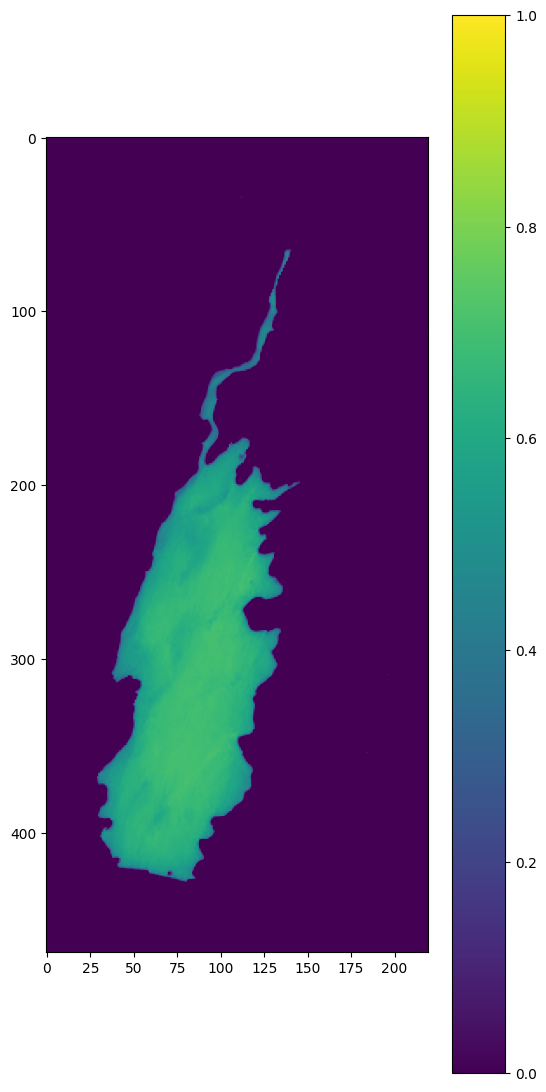

In [22]:
image_ar = eopatch.mask_timeless['NOMINAL_WATER'].shape[0] / eopatch.mask_timeless['NOMINAL_WATER'].shape[1]
print(image_ar)
# plot at different dates
fig = plt.figure(figsize=(20,15*image_ar))

# for i in range(12):
#     ax = plt.subplot(3,4,i+1)
#     im = ax.imshow(eopatch.data['MNDWI'][i].squeeze(), vmin = 0, vmax = 1)
#     ax.axis('on')
#     cb = fig.colorbar(im, orientation='vertical')
#     cb.ax.tick_params(labelsize=10)

ax = plt.subplot(3,4,1)
im = ax.imshow(eopatch.data['MNDWI'].squeeze(), vmin = 0, vmax = 1)
ax.axis('on')
cb = fig.colorbar(im, orientation='vertical')
cb.ax.tick_params(labelsize=10)

plt.tight_layout(pad=0)

In [23]:
def plot_waterbody(img, date, dam_poly, dam_bbox, water_extent, water_level,
                    color_nominal='white', color_current='xkcd:lime', ax = None):

    shape = img.shape[0:2]

    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

    ax.imshow(img,extent=[dam_bbox.min_x,dam_bbox.max_x,dam_bbox.min_y,dam_bbox.max_y])

    if isinstance(dam_poly, Polygon):
        draw_poly(ax,dam_poly, color=color_nominal)
    elif isinstance(dam_poly, MultiPolygon):
        draw_multi(ax,dam_poly, color=color_nominal)

    if isinstance(water_extent, Polygon):
        draw_poly(ax,water_extent, color=color_current)
    elif isinstance(water_extent, MultiPolygon):
        draw_multi(ax, water_extent, color=color_current)

In [24]:
import earthpy.plot as ep
from matplotlib.patches import Patch

def plot_rgb_w_water(eopatch, idx):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x) / np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio * 10, 10))
    #fig = plt.figure(figsize=(20,10))
    #ax = fig.add_subplot(111)

    ax.imshow(2*eopatch.data['BANDS'][..., [2, 1, 0]][idx])

    observed = closing(eopatch.mask['WATER_MASK'][idx,...,0], disk(1))
    nominal = sobel(eopatch.mask_timeless['NOMINAL_WATER'][...,0])
    observed = sobel(observed)
    nominal = np.ma.masked_where(nominal == False, nominal)
    observed = np.ma.masked_where(observed == False, observed)
    #leg = ax.legend([plt.Rectangle((0,0),1,1)],["Estimated Water"], loc='upper left',prop={'size':12})
    #plt.plot(nominal, label='Original Geometry')
    #plt.plot(observed, label='Estimated Surface Area')

    #plt.legend()
    ax.imshow(nominal, cmap=plt.cm.gray)
    ax.imshow(observed, cmap=plt.cm.Reds)
    legend_labels = {"gray": "Actual Geometry", "red": "Estimated Surface Area with Water"}
    patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

    ax.legend(handles=patches,
          bbox_to_anchor=(1.35, 1), loc="upper left",
          facecolor="white")

In [25]:
print(eopatch.bbox.min_y,eopatch.bbox.max_y)

33.540261699999995 33.6236905


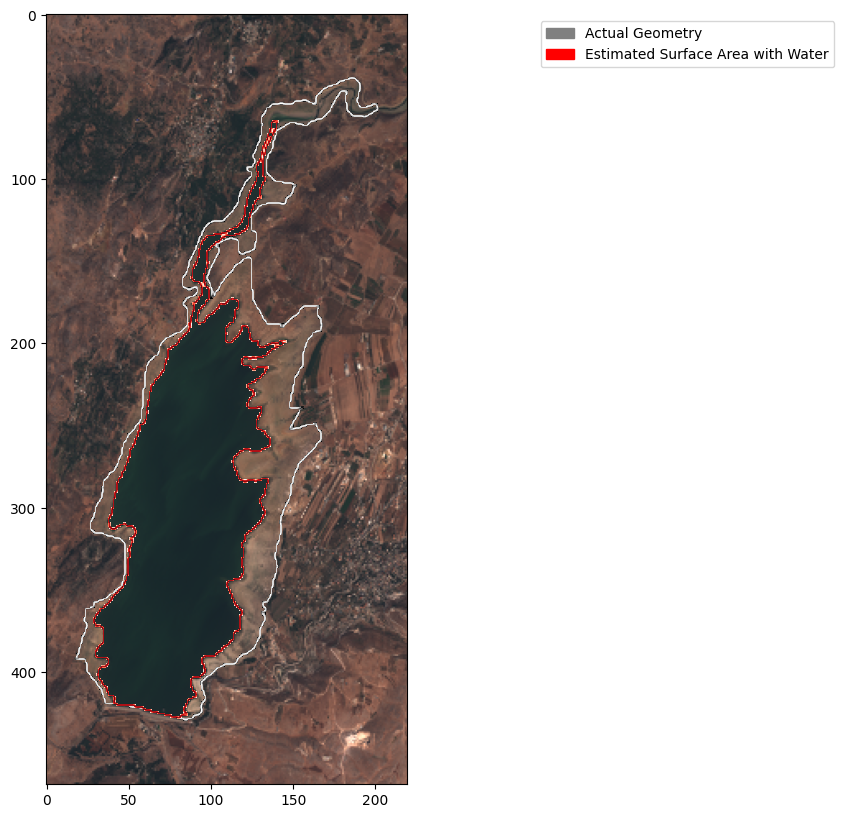

In [26]:
plot_rgb_w_water(eopatch, 0)

<generator object <genexpr> at 0x7f4294f05f50>
(35.67584534, 33.540261699999995, 35.72573966, 33.6236905) EPSG:4326


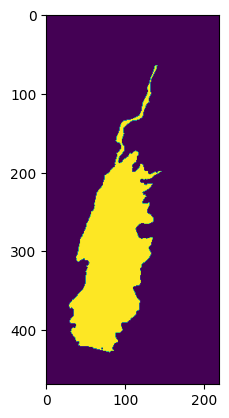

In [42]:
import numpy as np
import rasterio as rio
from rasterio.features import shapes

water_mask = eopatch['mask']['WATER_MASK'][0,...].astype(np.uint16)

H,W,B = water_mask.shape
bbox = eopatch['bbox']
bounds = (bbox.min_x,bbox.min_y,bbox.max_x,bbox.max_y)

transform = rio.transform.from_bounds(*bounds,W,H)

### Save as Tiff
with rio.open(
    f'./water_mask.tif',
    'w',
    driver='GTiff',
    height = H,
    width = W,
    count=1,
    dtype=np.uint16,
    crs=str(bbox.crs),
    transform=transform) as f:
    f.write(water_mask.transpose(2,0,1))

### Save as Shapefile
results = (
            {
        'properties': {'id': v}, 'geometry': s}
            for i, (s, v)
            in enumerate(
                shapes(water_mask[...,0], mask=None, transform=transform)) if v!=0)
print(results)
#gdf = gpd.GeoDataFrame.from_features(list(results))
#gdf = gdf.dissolve(by='id')
gdf = gpd.GeoDataFrame.from_features(list(results),crs=str(bbox.crs))
gdf = gdf.dissolve(by='id')
gdf.to_file(f'./water_mask.shp')
print(bounds,bbox.crs)
plt.imshow(water_mask)



In [ ]:
import numpy
x = eopatch.scalar['WATER_LEVEL']
y = eopatch.scalar['COVERAGE']
dates = np.asarray(eopatch.timestamps)
numpy.savetxt("date.json", dates, fmt='%s')
numpy.savetxt("level.json", x, delimiter=",")
numpy.savetxt("clouds.json", y, delimiter=",")

In [ ]:
an_array = np.array(eopatch.scalar['WATER_LEVEL'])
np.set_printoptions(suppress=True)
print(an_array)

In [ ]:
date = eopatch.timestamps[0].date()
date = date.strftime('%Y-%m-%d')

mask = eopatch.mask['WATER_MASK']
print(observed)
mask_serial = observed.tolist() # nested lists with same data, indices

#numpy.savetxt(date+'.json', mask, delimiter=",")

#detected_water_dict = gpd.GeoSeries([detected_water]).__geo_interface__
#date_formated = date.strftime("%Y-%m-%d")
with open('%s.json' % date, 'w') as fp:
  json.dump(mask_serial, fp)